# CPA on WeatherBench forecasts
Code and Data is from Weather Bench https://github.com/pangeo-data/WeatherBench

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from score import *

In [2]:
res = '5.625'
DATADIR = 'D:/'
PREDDIR = 'D:/baselines/'

In [3]:
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
cnn_3d = xr.open_dataset(f'{PREDDIR}fccnn_3d.nc')
tigge = xr.open_dataset(f'{PREDDIR}/tigge_{res}deg.nc')

In [4]:
t42 = xr.open_dataset(f'{PREDDIR}/t42_5.625deg.nc')
t63 = xr.open_dataset(f'{PREDDIR}/t63_5.625deg.nc')
lr_3d = xr.open_dataset(f'{PREDDIR}fc_lr_3d.nc')
persistence = xr.open_dataset(f'{PREDDIR}persistence_{res}.nc')

In [5]:
# define computation of rmse for latitiude
def compute_rmse_lat(da_fc, da_true):
    error = da_fc - da_true
    rmse = np.sqrt(((error)**2).mean(dim= ['time','lon']))
    if type(rmse) is xr.Dataset:
        rmse = rmse.rename({v: v + '_rmse' for v in rmse})
    else: # DataArray
        rmse.name = error.name + '_rmse' if not error.name is None else 'rmse'
    return rmse

def evaluate_iterative_forecast(fc_iter, da_valid):
    rmses = []
    for lead_time in fc_iter.lead_time:
        fc = fc_iter.sel(lead_time=lead_time)
        fc['time'] = fc.time + np.timedelta64(int(lead_time), 'h')
        rmses.append(compute_rmse_lat(fc, da_valid))
    return xr.concat(rmses, 'lead_time')

from scipy.stats import rankdata
def compute_cpa_lon(da_fc, da_true):
    latitude = da_true.lat.values
    longitude = da_true.lon.values
    time_stemp = (da_fc- da_true).time.values
    da_fc_2 = da_fc.sel(time=time_stemp)
    da_true_2 = da_true.sel(time=time_stemp)
    cpas = []
    for lat in latitude:
        cpa_lon = []
        a1 = da_true_2.sel(lat = lat)
        b1 =  da_fc_2.sel(lat = lat)
        for lon in longitude:
            a = a1.sel(lon = lon).values.flatten()
            b = b1.sel(lon = lon).values.flatten()
            responseOrder = np.argsort(a)
            responseSort = a[responseOrder] 
            forecastSort = b[responseOrder]                
            forecastRank = rankdata(forecastSort, method='average')
            responseRank = rankdata(responseSort, method='average')
            responseClass = rankdata(responseSort, method='dense')
            cpa_lon.append((np.cov(responseClass,forecastRank)[0][1]/np.cov(responseClass,responseRank)[0][1]+1)/2)
        cpas.append(np.mean(cpa_lon))    
    return(cpas)    

def evaluate_iterative_cpa_lon(fc_iter, da_valid):
    fc = fc_iter.sel(lead_time=3*24)
    fc['time'] = fc.time + np.timedelta64(int(3*24), 'h')
    return(compute_cpa_lon(fc, da_valid))

In [6]:
rmse_tigge = evaluate_iterative_forecast(tigge['t'], t850_valid).sel(lead_time=3*24).values
rmse_t42 = evaluate_iterative_forecast(t42['t'], t850_valid).sel(lead_time=3*24).values
rmse_t63 = evaluate_iterative_forecast(t63['t'], t850_valid).sel(lead_time=3*24).values
rmse_persistence = evaluate_iterative_forecast(persistence['t'], t850_valid).sel(lead_time=3*24).values
rmse_lr3d = compute_rmse_lat(lr_3d['t'], t850_valid)
rmse_cnn3d = compute_rmse_lat(cnn_3d['t'], t850_valid)

In [7]:
cpa_tigge = evaluate_iterative_cpa_lon(tigge['t'], t850_valid).sel(lead_time=3*24).values
cpa_t42 = evaluate_iterative_cpa_lon(t42['t'], t850_valid).sel(lead_time=3*24).values
cpa_t63 = evaluate_iterative_cpa_lon(t63['t'], t850_valid).sel(lead_time=3*24).values
cpa_persistence = evaluate_iterative_cpa_lon(persistence['t'], t850_valid).sel(lead_time=3*24).values
cpa_lr3d = compute_cpa_lon(lr_3d['t'], t850_valid)
cpa_cnn3d = compute_cpa_lon(cnn_3d['t'], t850_valid)

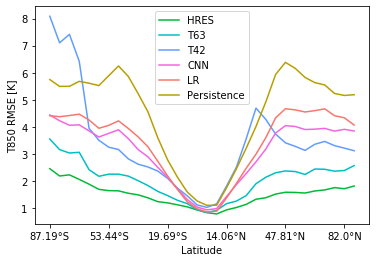

In [39]:
latitude = tigge.lat.values
col = ["#00BA38", "#00BFC4", "#619CFF", "#F564E3", "#F8766D", "#B79F00"]
plt.plot(rmse_tigge, color=col[0], label = "HRES")
plt.plot(rmse_t63, color=col[1], label="T63")
plt.plot(rmse_t42, color=col[2], label="T42")
plt.plot(rmse_cnn3d, color=col[3], label = "CNN")
plt.plot(rmse_lr3d, color=col[4], label="LR")
plt.plot(rmse_persistence, color=col[5], label="Persistence")
plt.xlabel('Latitude')
plt.ylabel('T850 RMSE [K]')
plt.legend()
ticks = plt.xticks(np.arange(0,32,6), (str(-np.round(latitude[0],2))+"°S", str(-np.round(latitude[6],2))+"°S", str(-np.round(latitude[12],2))+"°S", 
                           str(np.round(latitude[18],2))+"°N", str(np.round(latitude[24],2))+"°N", str(np.round(latitude[30]))+"°N"))

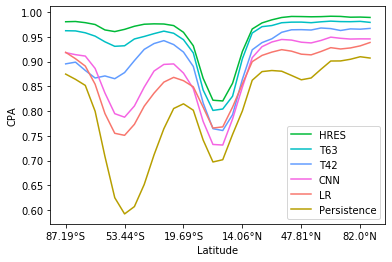

In [40]:
latitude = tigge.lat.values
col = ["#00BA38", "#00BFC4", "#619CFF", "#F564E3", "#F8766D", "#B79F00"]
plt.plot(cpa_tigge, color=col[0], label="HRES")
plt.plot(cpa_t63, color=col[1], label = "T63")
plt.plot(cpa_t42, color=col[2], label="T42")
plt.plot(cpa_cnn3d, color=col[3], label="CNN")
plt.plot(cpa_lr3d, color=col[4], label="LR")
plt.plot(cpa_persistence, color=col[5], label = "Persistence")
plt.xlabel('Latitude')
plt.ylabel('CPA')
plt.legend()
ticks = plt.xticks(np.arange(0,32,6), (str(-np.round(latitude[0],2))+"°S", str(-np.round(latitude[6],2))+"°S", str(-np.round(latitude[12],2))+"°S", 
                           str(np.round(latitude[18],2))+"°N", str(np.round(latitude[24],2))+"°N", str(np.round(latitude[30]))+"°N"))